### Introduction - Navier-Stokes driven cavity problem with PETSc in Proteus.


This notebook illustrates how to setup, solve and visualize a steady-state Navier-Stokes driven-cavity problem in Proteus using solver tools from the PETSc linear algebra library.


The driven-cavity problem is a standard benchmark for modeling Stokes and Navier-Stokes equations.  The simulation models a self-contained (e.g. no inflow or outflow) tank of fluid with an external force generating a velocity along the top of the tank.  For example, one could imagine a fan blowing over the top of an open fish tank full of water, causing the water along the surface to have an initial velocity. One (there are many others) nice reference for information about NSE and the driven-cavity problem is "Finite Elements and Faster Iterative Solvers" by Elman, Silvester and Wathen.


The governing equations for our problem are the well-known Navier-Stokes equations which we present in non-dimensional form.  Let $p: \Omega \rightarrow \mathbf{R}$, $\mathbf{v}:\Omega \rightarrow \mathbf{R} \times \mathbf{R}^n$ denote the unknown pressure and velocity of the system.  The Navier-Stokes equation relate these quantities through
$$
\nabla \cdot \mathbf{v}  = 0 
$$
$$
- \dfrac{1}{Re} \nabla \cdot (\nabla \mathbf{v}) + \mathbf{v} \cdot \nabla \mathbf{v} + \nabla p = \mathbf{f}.
$$
$Re$ is known as the Reynolds number.  As $Re$ increases, the non-linear convection term becomes more dominate to the system's behavior while as $Re$ decreases the the diffusion term will become more important to the system's behavior.  In many real world problems, $Re$ assumes a very large value, which results in convection dominated systems that are very challenging to solve numerically.

In this example, we are interested in solving this system with $Re$ on the order of 1000.  We will discuss more about this later in the tutorial.

Our domain of interest is a square 2D tank
$$
\Omega = [-1,1]^{2}
$$
 with the Dirichlet boundary conditons
$$
\mathbf{v} = 1 \text{ when } y = 1 
$$
and
$$
\mathbf{v} = 0 \text{ elsewhere on the boundary.}
$$


### Initialze Proteus Library

This first block of code loads and initialzes the libraries required to run the simulation.  numpy and petsc4py are non-proteus libraries that will allow us to use external python libraries for our linear algebra.  The proteus.iproteus command loads the interacitve proteus library.

The profiling commands enable output allowing us to track the progress of our simulation.  Increasing the log level will display more output.

In [1]:
import numpy as np
import petsc4py as petsc4py
from proteus.iproteus import * 

Profiling.logLevel = 3
Profiling.verbose = True

### The Navier-Stokes Class

Once the necessary libraries have been loaded, the next step is to create the NavierStokes class.  

In the initialization function (\__init\__), all the terms needed to define the Navier Stokes problem are specified.  Next in the evaluate function, we specify the terms required to evaluate the inner products that appear in the problem description.

Within the Proteus library, a large number of problem classes are already defined and for many simulations the user will not to define the particulars of this class.  We present this mainly for illustrative purposes.

In [2]:
class NavierStokes_1(TransportCoefficients.TC_base):
    """
    Coefficients for the NS problem
    """
    from proteus.ctransportCoefficients import NavierStokes_2D_Evaluate
    import numpy as np
    def __init__(self,rho=1.0,nu=1.0,g=[0.0,0.0],nd=2):
        self.rho = rho
        self.nu  = nu
        self.g   = np.array(g)
        self.nd  = nd
        mass = {}
        advection = {}
        diffusion = {}
        potential = {}
        reaction = {}
        hamiltonian = {}
        if nd==2:
            variableNames = ['p','u','v']
            mass = {1:{1:'linear'},
                    2:{2:'linear'}}
            advection = {0:{1:'linear',
                            2:'linear'},
                         1:{1:'nonlinear',
                            2:'nonlinear'},
                         2:{1:'nonlinear',
                            2:'nonlinear'}}
            diffusion = {0:{0:{0:'constant'}},
                         1:{1:{1:'constant'}},
                         2:{2:{2:'constant'}}}
            potential = {0:{0:'u'},
                         1:{1:'u'},
                         2:{2:'u'}}
            reaction = {1:{1:'constant'},
                        2:{2:'constant'}}
            hamiltonian = {1:{0:'linear'},
                           2:{0:'linear'}}
            TransportCoefficients.TC_base.__init__(self,
                                                   3,        # number of components (2-velocities 1-pressure)
                                                   mass,
                                                   advection,
                                                   diffusion,
                                                   potential,
                                                   reaction,
                                                   hamiltonian,
                                                   variableNames)
            self.vectorComponents = [1,2]
    def evaluate(self,t,c):
        if self.nd==2:
            self.NavierStokes_2D_Evaluate(self.rho,
                                          self.nu,
                                          self.g,
                                          c[('u',0)],
                                          c[('grad(u)',0)],
                                          c[('u',1)],
                                          c[('u',2)],
                                          c[('m',1)],
                                          c[('dm',1,1)],
                                          c[('m',2)],
                                          c[('dm',2,2)],
                                          c[('f',0)],
                                          c[('df',0,1)],
                                          c[('df',0,2)],
                                          c[('f',1)],
                                          c[('df',1,1)],
                                          c[('df',1,2)],
                                          c[('f',2)],
                                          c[('df',2,1)],
                                          c[('df',2,2)],
                                          c[('a',1,1)],
                                          c[('a',2,2)],
                                          c[('r',1)],
                                          c[('r',2)],
                                          c[('H',1)],
                                          c[('dH',1,0)],
                                          c[('H',2)],
                                          c[('dH',2,0)])

### Boundary Conditions

Boundary conditions are an important part of any numeric PDE solver.  In the next block of code we define two functions that will help use to specify problems boundary conditions. 

In [3]:

class uTrue:
    def __init__(self):
        pass
    def uOfX(self,x):
        return 1.
    def uOfXT(self,x,t):
        if t==1.0:
            return 1.
        if t==2.0:
            return 10.
        if t==3.0:
            return 100.
        if t==4.0:
            return 200.
        
class vTrue:
    def __init__(self):
        pass
    def vOfX(self,x):
        return 0.
    def vOfXT(self,x,t):
        return self.vOfX(x)


### The Proteus Phliosophy

Next we start getting into the particulars of setting up a simulation in Proteus.

Before proceeding, it is worth noting that Proteus aims to seperate the physics and the numerics of a problem as much as possible.  This compartmentalization allows researchers to focus on the particulars of their particular problem.

In order to facilate this seperation, each simulation is seperated into a set of physical and numerical parameters.


### Define the Physics

The first step in defining a problem's physics is to initialize our physics to default_p.  default_p is a collection of default values for the varies physics parameters the Proteus solver expects.  Once the physics has been initialized, we can then go about specifying the problem as we'd like.

In the code box below we override the Proteus defaults to build the driven cavity NS problem we are interested in solving.  See the inline comments for further details.


In [4]:
physics = default_p
physics.name = "nse_driven_cavity"

# this specifies the problem's dimension
physics.nd = 2

# There are several ways to specify a mesh in Proteus.  Perhaps the eaiset is to initialize
# a coordinate for the bottom left corner of the mesh (.x0) and the length of each coordinate
# axis (.L).
# Thus, the commands below creates a mesh with length 1 in the x and y direction with its bottom 
# left corner at the origin.
physics.x0 = [0.0,0.0]
physics.L = [1.0,1.0]

# Here we specify the simulation coefficients will come from a NavierStokes problem.  To illustrate
# its construction, the construction of this class is shown above.  Note that the Proteus library has
# prewritten classes for most common physics problems.
physics.coefficients = NavierStokes_1(rho=1.0,nu=1.0,g=[0.0,0.0],nd=2)

# Next we define functions for our problems boundary conditions.  Note that these functions
# refer to the earlier boundary condition functions and are not memebers of the the physics class.
def getDBCp(x,flag):
    pass

def getDBCu(x,flag):
    if (x[0] == physics.x0[0] or x[0] == (physics.x0[0]+physics.L[0]) or x[1] == physics.x0[1]):
        return lambda x,t: 0.0
    elif (x[1] == (physics.x0[1] + physics.L[1])):
        return lambda x,t: uTrue().uOfXT(x,t)

def getDBCv(x,flag):
    if (x[0] == physics.x0[0] or x[0] == (physics.x0[0]+physics.L[0]) or \
        x[1] == physics.x0[1] or x[1] == (physics.x0[1]+physics.L[1])):
        return lambda x,t: 0.0

def getAdvFluxBCp(x,flag):
    pass
    
def getAdvFluxBCu(x,flag):
    pass

def getAdvFluxBCv(x,flag):
    pass
    
# Here we attach the boundary condition functions written above to Proteus' physics class.  For this
# problem, the boundary conditions are fully specified by the Dirichlet conditions along the boundary.
# The boundary conditions corresponding to the advectiveFlux and pressure are just place holders.
physics.dirichletConditions = {0:getDBCp, 1:getDBCu, 2:getDBCv}
physics.advectiveFluxBoundaryConditions = {0:getAdvFluxBCp,1:getAdvFluxBCu,2:getAdvFluxBCv}

### Define the Numerics

As with the phyiscs, we start defining the numerics by loading the default values.

Following the initialization, there are three categories of information we specify: Mesh, FE Space and Linear Algebra and Solver Options.

Mesh -

While the dimensions and location of the domain are speicified as part of the simulation's physics, aspects of the refinment are speicifed as part of the simulation's numerics.  In this example, we specify that each coordinate axis of the mesh should have 41 nodes.  While other mesh options are avaliable, these will be demonstrated in other tutorials.

FE Space -

Proteus supports several choices of finite elements to solve Stokes and Navier-Stokes problems.  In this example we 


In [5]:
numerics = default_n

# ******* MESH ********
# this specifies the number of mesh nodes in the x and y directions 
numerics.nn = 41

# ******* FE SPACE *********
# these options specify the finite element space used to approximate the solution

numeric_scheme = "TH" #Options: TH or C0P1C0P1

if numeric_scheme == "TH":
    numerics.femSpaces = {0:FemTools.C0_AffineLinearOnSimplexWithNodalBasis, #pressure space
                          1:FemTools.C0_AffineQuadraticOnSimplexWithNodalBasis,
                          2:FemTools.C0_AffineQuadraticOnSimplexWithNodalBasis}  #velocity space

elif numeric_scheme == "C0P1C0P1":
    numerics.femSpaces = {0:FemTools.C0_AffineLinearOnSimplexWithNodalBasis,
                          1:FemTools.C0_AffineLinearOnSimplexWithNodalBasis,
                          2:FemTools.C0_AffineLinearOnSimplexWithNodalBasis}
    numerics.subgridError = SubgridError.NavierStokesASGS_velocity_pressure(physics.coefficients,physics.nd,lag=False)

elif numeric_scheme == "THQuads":
    femSpaces = {0:FemTools.C0_AffineLinearOnCubeWithNodalBasis,
                 1:FemTools.Q2,
                 2:FemTools.Q2}

if numeric_scheme == "TH" or numeric_scheme == "C0P1C0P1":
    numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,4)
    numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,4)

elif numeric_scheme == "THQuads":
    numerics.elementQuadrature = Quadrature.CubeGaussQuadrature(physics.nd,4)
    numerics.elementBoundaryQuadrature = Quadrature.CubeGaussQuadrature(physics.nd-1,4)
    
# ******** LINEAR ALGEBRA AND SOLVER OPTIONS ********
    
#numerics.numericalFluxType = NumericalFlux.Diffusion_IIPG_exterior
numerics.matrix = LinearAlgebraTools.SparseMatrix

numerics.multilevelNonlinearSolver = NonlinearSolvers.Newton
numerics.levelNonlinearSolver = NonlinearSolvers.Newton
numerics.maxNonlinearIts = 100
numerics.maxLineSearches = 100

numerics.linearSmoother = LinearSolvers.NavierStokes3D
numerics.l_atol_res = 1.0e-8
numerics.nl_atol_res = 1.0e-4

solveIteratively = False
iterativeSolver = 'schur'  # options: 'asm', 'schur', 'direct'

if solveIteratively:
    numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
    numerics.levelLinearSolver = LinearSolvers.KSP_petsc4py
    if iterativeSolver == 'asm':
        petsc4py.PETSc.Options().setValue("ksp_type","gmres")
        petsc4py.PETSc.Options().setValue("pc_type","asm")
        petsc4py.PETSc.Options().setValue("sub_pc_type","lu")
    if iterativeSolver == 'schur':
        petsc4py.PETSc.Options().setValue("ksp_type","fgmres")
        petsc4py.PETSc.Options().setValue("pc_type","fieldsplit")
        petsc4py.PETSc.Options().setValue("pc_fieldsplit_type","schur")
        petsc4py.PETSc.Options().setValue("pc_fieldsplit_schur_fact_type","full")
        petsc4py.PETSc.Options().setValue("pc_fieldsplit_precondition","selfp")
        petsc4py.PETSc.Options().setValue("fieldsplit_velocity_ksp_type","preonly")
        petsc4py.PETSc.Options().setValue("fieldsplit_velocity_pc_type","asm")
    #numerics.numericalFluxType = NumericalFlux.NavierStokes_Advection_DiagonalUpwind_Diffusion_IIPG_exterior
    numerics.numericalFluxType = NumericalFlux.Diffusion_IIPG_exterior
else:
    numerics.multilevelLinearSolver = LinearSolvers.LU
    numerics.levelLinearSolver = LinearSolvers.LU
    numerics.numericalFluxType = NumericalFlux.Diffusion_IIPG_exterior
#    numerics.numericalFluxType = None
    


### Initialize SO

In [12]:
so = default_so
so.name = physics.name
so.sList = [default_s]
so.tnList = [0.0,1.0,2.0,3.0]
#so.tnList = [0.0,1.0,2.0,3.0,4.0]

### Solve the Problem

In [13]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
ns.calculateSolution('run1')

# save solution and grid data for plotting purposes
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
p = ns.modelList[0].levelModelList[-1].u[0].dof
u = ns.modelList[0].levelModelList[-1].u[1].dof
v = ns.modelList[0].levelModelList[-1].u[2].dof

[      69] Initializing NumericalSolution for nse_driven_cavity
 System includes: 
nse_driven_cavity

[      69] Setting Archiver(s)
[      69] Setting up MultilevelMesh
[      69] Building one multilevel mesh for all models
[      69] Generating mesh for nse_driven_cavity
[      69] Building 41 x 41 rectangular mesh for nse_driven_cavity
[      69] Partitioning mesh among 1 processors using partitioningType = 1
[      69] Number of Subdomain Elements Owned= 3200
[      69] Number of Subdomain Elements = 3200
[      69] Number of Subdomain Nodes Owned= 1681
[      69] Number of Subdomain Nodes = 1681
[      69] Number of Subdomain elementBoundaries Owned= 4880
[      69] Number of Subdomain elementBoundaries = 4880
[      69] Number of Subdomain Edges Owned= 4880
[      69] Number of Subdomain Edges = 4880
[      69] Finished partitioning
[      69] *** Global ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1681

*** Local ***
Number of triangles  : 3200
Number

### Visualize the Solution

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


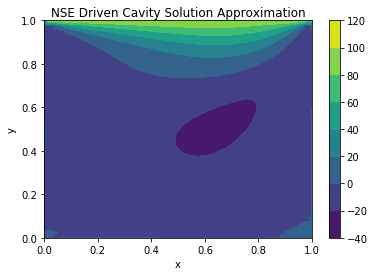

In [15]:
import matplotlib.pyplot as plt
plt.clf()
plt.tricontourf(x,y,triangles,u[:x.shape[0]])
plt.xlabel('x'); plt.ylabel('y')
plt.title('NSE Driven Cavity Solution Approximation'); plt.colorbar()
plt.show()

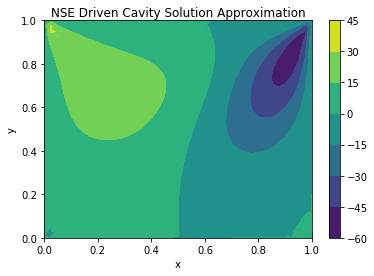

In [16]:
import matplotlib.pyplot as plt
plt.clf()
plt.tricontourf(x,y,triangles,v[:x.shape[0]])
plt.xlabel('x'); plt.ylabel('y')
plt.title('NSE Driven Cavity Solution Approximation'); plt.colorbar()
plt.show()

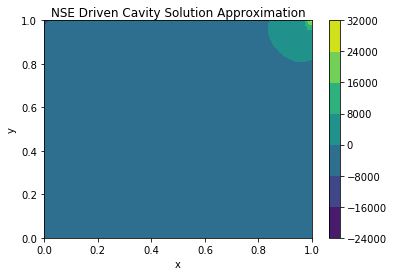

In [17]:
import matplotlib.pyplot as plt
plt.clf()
plt.tricontourf(x,y,triangles,p[:x.shape[0]])
plt.xlabel('x'); plt.ylabel('y')
plt.title('NSE Driven Cavity Solution Approximation'); plt.colorbar()
plt.show()